PLease find the detailed discussion of variational autoencoders in the attached documentation

Download the CelebA dataset

In [1]:
!gdown --id 1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW

Downloading...
From: https://drive.google.com/uc?id=1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW
To: /mnt/data/img_align_celeba.zip
100%|██████████████████████████████████████| 1.44G/1.44G [00:21<00:00, 67.9MB/s]


In [ ]:
Unzip the data to folder data

In [2]:
!unzip img_align_celeba.zip -d data

Archive:  img_align_celeba.zip
replace data/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


After have some pilot projects with Tensorflow,Keras and PyTorch I decided to use the later one as it is much simpler to implement Variational Autoencoder with it.
GPU optimalisation is essentiala check is done for availability

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch.optim as  optim 
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)

gpu up


Reading the csv for attributes

In [11]:
df = pd.read_csv("data/list_attr_celeba.csv")

In [12]:
def haircolor(x):
    if x["Blond_Hair"] == 1:
        return 0
    elif x["Brown_Hair"] == 1:
        return 1
    elif x["Black_Hair"] == 1:
        return 2
    else :
        return 3
    
df["Hair_Color"] = df.apply(haircolor,axis=1)

In [27]:
"""
for simplicity I decided to make the VAE capture just for attributes 

Hair Color (blond,brown,black and neither of these(or unknown))
Pale Skin 
Gender 
Beard (in case of male)
"""

df = df[["image_id","Hair_Color",'Pale_Skin',"Male","No_Beard"]]

In [14]:
"""
replacing -1 with 0 without affecting the the 1 values 

"""
df.Pale_Skin = df.Pale_Skin.apply(lambda x: max(x,0)) 
df.Male = df.Male.apply(lambda x: max(x,0))
df.No_Beard = df.No_Beard.apply(lambda x: max(x,0))


In [15]:
df

,image_id,Hair_Color,Pale_Skin,Male,No_Beard
0,000001.jpg,1,0,0,1
1,000002.jpg,1,0,0,1
2,000003.jpg,3,0,1,1
3,000004.jpg,3,0,0,1
4,000005.jpg,3,0,0,1
...,...,...,...,...,...
202594,202595.jpg,0,0,0,1
202595,202596.jpg,0,1,1,1
202596,202597.jpg,2,0,1,1
202597,202598.jpg,2,0,0,1


In [ ]:
def ceil(a,b):
    return -(-a//b)

In [16]:
faces =[]
for i in df.iloc[:20000].image_id:
    pic = Image.open("data/img_align_celeba/"+i)
    pic = pic.resize((64,64))
    pix = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)
    pix = pix/255
    """
    for the images I had to use np.moveaxis to change the shape from  (64,64,3) to (3,64,64)
    without messing up the image 
    
    """
    faces.append(np.moveaxis(pix,-1,0).tolist())
    
faces = np.array(faces)

Some ideas for implementing AutoEncoders in PyTorch were used from this page and (links opening from here):
https://discuss.pytorch.org/t/autoencoders-in-pytorch/844

In [32]:
class Encoder(nn.Module):
    def __init__(self):
        
        super(Encoder,self).__init__()
        # parameters from https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html 
        # channels_in, channels_out, kernel_size, stride , padding,
        self.conv1 = nn.Conv2d(3,64,3,1,1)
        self.maxp1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(64,64,3,1,1)
        self.maxp2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv3 = nn.Conv2d(64,64,4,2,1)
        self.maxp3 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv4 = nn.Conv2d(64,128,4,2,1)
        self.maxp4 = nn.MaxPool2d(kernel_size=2,stride=2)


    # forward fuction for Encoder    
    def forward(self,x):
        out = self.conv1(x)
        out = self.maxp1(out)
        out = F.relu(out) 
        
        out = self.conv2(out)
        out = self.maxp2(out)
        out = F.relu(out)
        
        out = self.conv3(out)
        out = self.maxp3(out)
        out = F.relu(out)
        
        out= self.conv4(out)
        out = self.maxp4(out)
        out = F.relu(out)
        
        return out.view(out.shape[0],-1)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        """
        ConvTranspose2d is very similar to the convolution operation but the convolution matrix is transposed, 
        so the result is that the output grows instead of reducing(depending on the padding, stride and kernel size used). 
        Parameters are:
        # in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0
        """
        self.transconv1 = nn.ConvTranspose2d(64+ 40,64,8,4,2)
        self.transconv2 = nn.ConvTranspose2d(64,64,8,4,2)
        self.transconv3 = nn.ConvTranspose2d(64,64,4,2,1)
        self.transconv4 = nn.ConvTranspose2d(64,3,4,2,1)
        
        """
        Embedding layers were used which are a simple lookup tables that stores embeddings of a fixed dictionary and size.
        Some features were converted into a vector to get a conditional VAE
        I.e. Hair 'states' were converted into a vector of 10 weights
        
        """
        self.hairEmbedding = nn.Embedding(4,10)
        self.beardEmbedding = nn.Embedding(2,10)
        self.genderEmbedding = nn.Embedding(2,10)
        self.paleSkinEmbedding = nn.Embedding(2,10)

        
    def forward(self,x):
        """
        Here z are sampled from x (encoded image)
        and then feature vectors are concatenating to z
        """
        z = x[:,:64]
        hair = self.hairEmbedding(x[:,64].long())
        paleSkin = self.paleSkinEmbedding(x[:,65].long())
        gender = self.genderEmbedding(x[:,66].long())
        beard = self.beardEmbedding(x[:,67].long())
        
        z = torch.cat([z,hair,beard,gender,paleSkin],dim=1)
        
        # ConvTranspose2d layers were used to the increasing the dimension of the output
        
        out= self.transconv1(z.view(z.shape[0],z.shape[1],1,1))
        out = F.relu(out)
        
        out= self.transconv2(out)
        out = F.relu(out)

        out= self.transconv3(out)
        out = F.relu(out)

        out= self.transconv4(out)
        out = F.relu(out)

        return out
        
class CVAE(nn.Module):
    def __init__(self,encoder,decoder):
        # Here I used super fuction, which returns a proxy object that delegates method calls to a parent class (ie.: nn.Module right now) of type.
        # This is useful for accessing inherited methods that have been overridden in a class. 
        super(CVAE,self).__init__() # 
        self.encoder = encoder()
        self.decoder = decoder()
        
    def forward(self,x,attrs):
        h = self.encoder(x)
        
        mu = h[:,:64]
        logvar = h[:,64:]
        '''
        Here we use a well-known reparameterization trickof VAEs
        for more details please have a look at my assignment documentation 
        (based on https://towardsdatascience.com/reparameterization-trick-126062cfd3c3)
        '''
        s= torch.exp(logvar)
        eps = torch.randn_like(s)
        z = s*eps + mu 
        
        z= torch.cat([z,attrs],dim=1)
        out = self.decoder(z)
        return out,mu,logvar
        
vae = CVAE(Encoder,Decoder)
vae.to(device)

CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (transconv1): ConvTranspose2d(104, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv2): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [19]:

"""
Now, the loss function is implemented with reconstruction loss and 
the difference between the distribtions (measured with the classic metric for it: Kullback-Leibler divergence.
https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
"""

def loss_function(recon_x,x,mu,logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= x.shape[0] * 3 * 64 * 64
    recon_loss = F.mse_loss(recon_x,x)
    return recon_loss +  KLD

epochs = 200 #1201

batch_size= 16 # 256
# https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html
# Adaptive Subgradient Methods for Online Learning and Stochastic Optimization
optimizer = optim.Adagrad(vae.parameters(),lr = 0.001)

npData = df.iloc[:20000].to_numpy()


n_samples = len(npData)

better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))
losstrack = []
for e in range(epochs):
    losses = []
    for i in range(ceil(n_samples, better_batch_size)):
        batch = npData[i * better_batch_size: (i+1) * better_batch_size]
        attrs = torch.Tensor(batch[:,1:].astype('float16')).to(device)
#         break
        imgs = faces[i * better_batch_size: (i+1) * better_batch_size]
        imgs = torch.Tensor(imgs.astype('float16')).to(device)
        vae.zero_grad()
        recon_imgs,mu,logvar = vae(imgs,attrs)
        err = loss_function(recon_imgs,imgs,mu,logvar)
        err.backward()
        optimizer.step()
        losses.append(err.item())
    losstrack.append(np.mean(losses))
    if e % 2 == 0: 
        torch.save(vae.state_dict(), "./vae.pt")
        print(np.mean(losses), "mean loss", e)

        


0.05719310665428638 mean loss 0
0.03993025882393122 mean loss 2
0.03841225204318762 mean loss 4
0.03766218939423561 mean loss 6
0.03717552060186863 mean loss 8
0.03675632480382919 mean loss 10
0.036470516246557234 mean loss 12
0.03624497902095318 mean loss 14
0.03603646744638681 mean loss 16
0.03588213740885258 mean loss 18
0.03571493095159531 mean loss 20
0.03557597676813602 mean loss 22
0.035443005394935605 mean loss 24
0.035365896578133105 mean loss 26
0.035258941341936585 mean loss 28
0.03517602515816688 mean loss 30
0.03477565557807684 mean loss 32
0.034244394275546076 mean loss 34
0.03410927238762379 mean loss 36
0.034011883506178855 mean loss 38
0.03394143545627594 mean loss 40
0.033863054615259174 mean loss 42
0.03378425393551588 mean loss 44
0.03371996296197176 mean loss 46
0.03363377388864756 mean loss 48
0.03358212163895369 mean loss 50
0.03352904502302408 mean loss 52
0.03344002543240786 mean loss 54
0.033367064376175405 mean loss 56
0.033278899586200714 mean loss 58
0.0332

In [20]:
"""The model I saved while training (vae.pt) is loaded"""

checkpoint = torch.load("vae.pt")
vae.load_state_dict(checkpoint)

<All keys matched successfully>

In [21]:
def showImage(x):
    attrs = torch.Tensor(x)
    h = torch.cat((torch.randn(1,64),attrs),dim=1).to(device)
    img = vae.decoder(h)
    img = img.cpu().detach().numpy().reshape(3,64,64)
    img = np.moveaxis(img,0,-1)
    return img

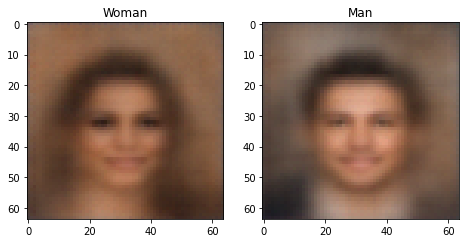

In [22]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,1]]))
axarr[0].set_title("Woman")
axarr[1].imshow(showImage([[2,0,1,0]]))
axarr[1].set_title("Man")

f.subplots_adjust(hspace=0.3,left=2,right=3)

Here showing what could the model do after the training 

it could kinda generate different genders

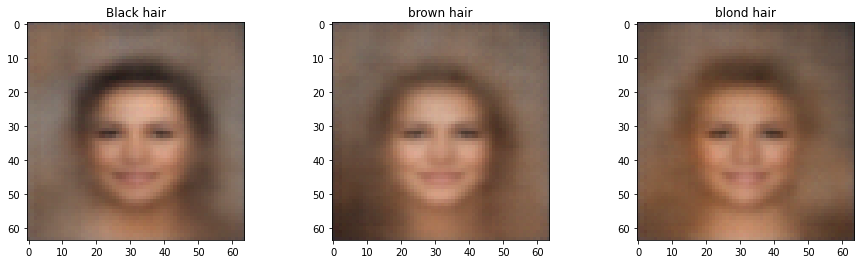

In [23]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(showImage([[2,0,0,1]]))
axarr[0].set_title("Black hair")
axarr[1].imshow(showImage([[1,0,0,1]]))
axarr[1].set_title("brown hair")
axarr[2].imshow(showImage([[0,0,0,1]]))
axarr[2].set_title("blond hair")


f.subplots_adjust(hspace=0.3,left=2,right=4)

it also can make different hair colors but it mostly was trying to just fill the image outside with the color

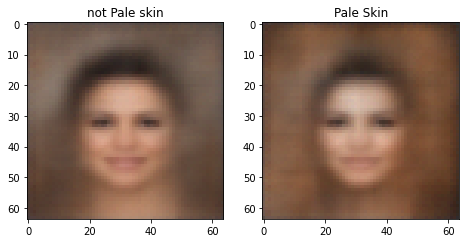

In [24]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,1]]))
axarr[0].set_title("not Pale skin")
axarr[1].imshow(showImage([[2,1,0,1]]))
axarr[1].set_title("Pale Skin")

f.subplots_adjust(hspace=0.3,left=2,right=3)

it could get doing the skin part correctly 

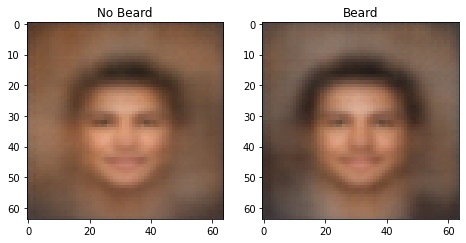

In [25]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,1,1]]))
axarr[0].set_title("No Beard")
axarr[1].imshow(showImage([[2,0,1,0]]))
axarr[1].set_title("Beard")

f.subplots_adjust(hspace=0.3,left=2,right=3)

Text(0.5, 1.0, 'blond hair')

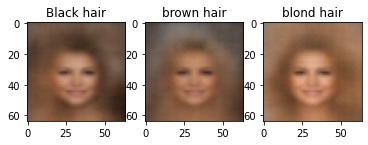

In [26]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(showImage([[0,0,0,1]]))
axarr[0].set_title("Black hair")
axarr[1].imshow(showImage([[0,0,0,1]]))
axarr[1].set_title("brown hair")
axarr[2].imshow(showImage([[0,0,0,1]]))
axarr[2].set_title("blond hair")

well this one is not good maybe the model needs to be bigger(and also more data)  because there is barely a difference between the two images 

upvote if you find this kernel useful